In [1]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_provider import IBMProvider

In [2]:
provider = IBMProvider()

# backends = provider.backends(simulator=False, operational=True)

# # choose IBMQ backend
# backend = least_busy(backends)

backend = provider.get_backend("ibmq_belem")

backend.name

'ibmq_belem'

In [3]:
from qiskit.utils import algorithm_globals
from qiskit.algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit_optimization import QuadraticProgram
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np

In [4]:
def name_nodes(qubo, plants_counts, field_count, years_count):
    # Create a cube
    for plant in range(plants_count):
        for field in range(field_count):
            for year in range(year_count):
                name = f"x_p{plant}_l{field}_t{year}"
                qubo.binary_var(name)
                
                # In the form: 
                # qubo.binary_var("x_p1_l1_t2")

In [6]:
qubo = QuadraticProgram()

# Parameters:     
# soil quality - what's the nitrogen availability 
# in the soil (a grade between 0 and 1)
# Note: In the beginning all the parameters are ideal 
# soil_quality = 1
qubo.binary_var("soil_quality")

# Per unit field in dollars
# fertilizer_price = 10.55
qubo.binary_var("fertilizer_price")

# A unit area of a field
# field_area = 1
qubo.binary_var("field_area")

# Environment factor (?) - a grade between 0 and 1
# env = 1
qubo.binary_var("env")

# Nodes in the 3D cube: checkout the documentation
# Number of crops type
plants_count = 2
# Number of available field in which the crops should rotate
fields_count = 2
# Number of years/seasons for rotating the crops
years_count = 2

name_nodes(qubo, plants_count, fields_count, years_count)

# qubo.minimize(linear=[], quadratic={("env", "fertilizer_price", ""): 1, ("x", "z"): -1, ("y", "z"): 2})
# print(qubo.prettyprint())

Problem name: 

Minimize
  x*y - x*z + 2*y*z + x - 2*y + 3*z

Subject to
  No constraints

  Binary variables (3)
    x y z



In [10]:
op, offset = qubo.to_ising()
print("offset: {}".format(offset))
print("operator:")
print(op)

offset: 1.5
operator:
-0.5 * IIZ
+ 0.25 * IZI
- 1.75 * ZII
+ 0.25 * IZZ
- 0.25 * ZIZ
+ 0.5 * ZZI


In [11]:
qp = QuadraticProgram()
qp.from_ising(op, offset, linear=True)
print(qp.prettyprint())

Problem name: 

Minimize
  x0*x1 - x0*x2 + 2*x1*x2 + x0 - 2*x1 + 3*x2

Subject to
  No constraints

  Binary variables (3)
    x0 x1 x2



In [14]:
## initializing the MinimumEigensolver we want to use
algorithm_globals.random_seed = 10598
qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA(), initial_point=[0.0, 0.0])
exact_mes = NumPyMinimumEigensolver()

In [15]:
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solver

In [16]:
exact_result = exact.solve(qubo)
print(exact_result.prettyprint())

objective function value: -2.0
variable values: x=0.0, y=1.0, z=0.0
status: SUCCESS


In [17]:
qaoa_result = qaoa.solve(qubo)
print(qaoa_result.prettyprint())

objective function value: -2.0
variable values: x=0.0, y=1.0, z=0.0
status: SUCCESS


In [18]:
print("variable order:", [var.name for var in qaoa_result.variables])
for s in qaoa_result.samples:
    print(s)

variable order: ['x', 'y', 'z']
SolutionSample(x=array([0., 1., 0.]), fval=-2.0, probability=0.4410900880690431, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0.]), fval=0.0, probability=0.2276092830372722, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 0.]), fval=0.0, probability=0.1413052418997499, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0.]), fval=1.0, probability=0.1257222100828826, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1.]), fval=3.0, probability=0.0205255745635282, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 1.]), fval=3.0, probability=0.03044357461683, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 1.]), fval=3.0, probability=0.0123872794392166, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 1.]), fval=4.0, probability=0.0009167482914771, status=

In [21]:
def get_filtered_samples(
    samples: List[SolutionSample],
    threshold: float = 0,
    allowed_status: Tuple[OptimizationResultStatus] = (OptimizationResultStatus.SUCCESS,),
):
    res = []
    for s in samples:
        if s.status in allowed_status and s.probability > threshold:
            res.append(s)

    return res

In [22]:
filtered_samples = get_filtered_samples(
    qaoa_result.samples, threshold=0.005, allowed_status=(OptimizationResultStatus.SUCCESS,)
)
for s in filtered_samples:
    print(s)

SolutionSample(x=array([0., 1., 0.]), fval=-2.0, probability=0.4410900880690431, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0.]), fval=0.0, probability=0.2276092830372722, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 0.]), fval=0.0, probability=0.1413052418997499, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0.]), fval=1.0, probability=0.1257222100828826, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1.]), fval=3.0, probability=0.0205255745635282, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 1.]), fval=3.0, probability=0.03044357461683, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 1.]), fval=3.0, probability=0.0123872794392166, status=<OptimizationResultStatus.SUCCESS: 0>)


In [23]:
fvals = [s.fval for s in qaoa_result.samples]
probabilities = [s.probability for s in qaoa_result.samples]

In [24]:
samples_for_plot = {
    " ".join(f"{qaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(s.x)): s.probability
    for s in filtered_samples
}
samples_for_plot

{'x=0 y=1 z=0': 0.4410900880690431,
 'x=0 y=0 z=0': 0.2276092830372722,
 'x=1 y=1 z=0': 0.1413052418997499,
 'x=1 y=0 z=0': 0.1257222100828826,
 'x=0 y=0 z=1': 0.0205255745635282,
 'x=1 y=0 z=1': 0.03044357461683,
 'x=0 y=1 z=1': 0.0123872794392166}

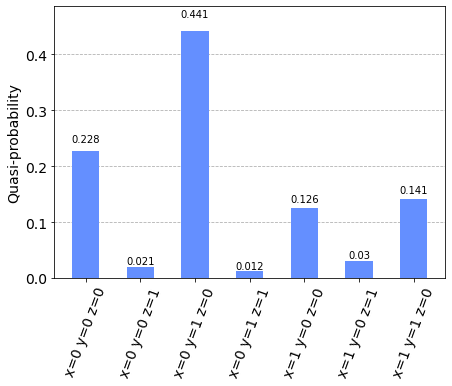

In [25]:
plot_histogram(samples_for_plot)